In [51]:
from transformers import AutoModelForPreTraining, AutoTokenizer, AutoModelForSequenceClassification

from fastai.data.external import untar_data
from fastbook import *

In [63]:
from sklearn.datasets import load_files
import datasets
from datasets import load_dataset, Dataset

In [85]:
model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True, max_length=512)
model = AutoModelForPreTraining.from_pretrained(model_checkpoint)  # equivalent as AutoModelForMaskedLM but more general

## 1. Load and preprocess the dataset for language model

In [49]:
path = untar_data(URLs.IMDB)
(path).ls()

(#7) [Path('/storage/data/imdb/README'),Path('/storage/data/imdb/imdb.vocab'),Path('/storage/data/imdb/tmp_lm'),Path('/storage/data/imdb/tmp_clas'),Path('/storage/data/imdb/unsup'),Path('/storage/data/imdb/test'),Path('/storage/data/imdb/train')]

In [56]:
train_data = load_files(path/'train')
test_data = load_files(path/'test')

In [57]:
train_text = [str(text) for text in train_data.data]
test_text = [str(text) for text in test_data.data]
all_texts = np.concatenate([train_text, test_text])
all_texts.shape

(50000,)

In [75]:
train_dataset = Dataset.from_dict({'text': all_texts[:-1000]})
test_dataset = Dataset.from_dict({'text': all_texts[-1000:]})

In [94]:
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=512, truncation=True)

In [96]:
tokenized_test_datasets = test_dataset.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])
tokenized_train_datasets = train_dataset.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])

## 2. Fine-tune the language model (DART/TART)

The `lm_head` is different from `GPT-2`, which is a single linear layer

```
 (lm_head): RobertaLMHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (decoder): Linear(in_features=768, out_features=50265, bias=True)
  )
```

The `classifier` head is similarly two layers:

```
 (classifier): RobertaClassificationHead(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (out_proj): Linear(in_features=768, out_features=2, bias=True)
  )
```

In [18]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

TODO: refer to the following notebook:
        
https://colab.research.google.com/github/huggingface/notebooks/blob/master/examples/language_modeling.ipynb#scrollTo=nRZ-5v_P3l_b

Before we move on to the fine-tuning part, let's have a look at this `tokenizer` and this `model`. The tokenizers in HuggingFace usually do the tokenization and the numericalization in one step (we ignore the padding warning for now):

In [39]:
sequence = f"Jesus is our Lord and {tokenizer.mask_token}."
ids = tokenizer.encode(sequence, return_tensors="pt")
ids

tensor([[    0, 33877,    16,    84,  5736,     8, 50264,     4,     2]])

Like fastai `Transform`s, the tokenizer has a `decode` method to give you back a text from ids:

In [32]:
tokenizer.decode(ids[0])

'<s>Jesus is our Lord and<mask>.</s>'

In [37]:
import torch
mask_token_index = torch.where(ids == tokenizer.mask_token_id)[1]

token_logits = model(ids)[0]
mask_token_logits = token_logits[0, mask_token_index, :]

top_3_tokens = torch.topk(mask_token_logits, 3, dim=1).indices[0].tolist()

In [40]:
for token in top_3_tokens:
    print(tokenizer.decode([token]), ":")
    print(sequence.replace(tokenizer.mask_token, tokenizer.decode([token])))

 Savior :
Jesus is our Lord and  Savior.
 savior :
Jesus is our Lord and  savior.
 Son :
Jesus is our Lord and  Son.


The predictions, by default, are of length 20:

In [24]:
preds.shape,preds[0]

(torch.Size([1, 15]),
 tensor([    0, 33877,    16,    84,  5736,     8, 50264,     9,   201,     4,
            91,   851,   201,     2,     2]))

We can use the decode method (that prefers a numpy array to a tensor):

In [25]:
tokenizer.decode(preds[0].numpy())

'<s>Jesus is our Lord and<mask> of us. He gave us</s></s>'

## Bridging the gap with fastai

Now let's see how we can use fastai to fine-tune this model on wikitext-2, using all the training utilities (learning rate finder, 1cycle policy etc...). First, we import all the text utilities:

In [15]:
from fastai.text.all import *

In [16]:
from sklearn.datasets import load_files

### Preparing the data

Then we download the dataset (if not present), it comes as two csv files:

In [19]:
path = untar_data(URLs.IMDB)
(path).ls()

(#7) [Path('/storage/data/imdb/README'),Path('/storage/data/imdb/imdb.vocab'),Path('/storage/data/imdb/tmp_lm'),Path('/storage/data/imdb/tmp_clas'),Path('/storage/data/imdb/unsup'),Path('/storage/data/imdb/test'),Path('/storage/data/imdb/train')]

In [20]:
train_data = load_files(path/'train')
test_data = load_files(path/'test')

Let's have a look at what those csv files look like:

We gather all texts in one numpy array (since it will be easier to use this way with fastai):

In [22]:
train_text = [str(text) for text in train_data.data]
test_text = [str(text) for text in test_data.data][:1000]
all_texts = np.concatenate([train_text, test_text])
all_texts.shape

(26000,)

To process this data to train a model, we need to build a `Transform` that will be applied lazily. In this case we could do the pre-processing once and for all and only use the transform for decoding (we will see how just after), but the fast tokenizer from HuggingFace is, as its name indicates, fast, so it doesn't really impact performance to do it this way.

In a fastai `Transform` you can define:
- an <code>encodes</code> method that is applied when you call the transform (a bit like the `forward` method in a `nn.Module`)
- a <code>decodes</code> method that is applied when you call the `decode` method of the transform, if you need to decode anything for showing purposes (like converting ids to a text here)
- a <code>setups</code> method that sets some inner state of the `Transform` (not needed here so we skip it)

In [23]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

Two comments on the code above:
- in <code>encodes</code> we don't use the `tokenizer.encode` method since it does some additional preprocessing for the model after tokenizing and numericalizing (the part throwing a warning before). Here we don't need any post-processing so it's fine to skip it.
- in <code>decodes</code> we return a `TitledStr` object and not just a plain string. That's a fastai class that adds a `show` method to the string, which will allow us to use all the fastai show methods.

You can then group your data with this `Transform` using a `TfmdLists`. It has an s in its name because it contains the training and validation set. We indicate the indices of the training set and the validation set with `splits` (here all the first indices until `len(df_train)` and then all the remaining indices):

In [24]:
splits = [range_of(train_text), list(range(len(train_text), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

We specify `dl_type=LMDataLoader` for when we will convert this `TfmdLists` to `DataLoaders`: we will use an `LMDataLoader` since we have a language modeling problem, not the usual fastai `TfmdDL`.

In a `TfmdLists` you can access the elements of the training or validation set quite easily:

In [25]:
tls.train[0],tls.valid[0]

(tensor([   65,     1, 28667,  3596,  5983,   345,   284,   892,    11,   772,
           302,    12, 14925,  1521,   734,  6510,    14, 35465,  1450,   561,
           466,   644,   484,   750,   532,  4589, 13584,  7341,  2884, 17968,
           278,   511, 28999,    13,   632, 23007,   644,  1276,   307,  3675,
           257, 13699,  4235,   286,   852,   329,   734,  5384,   508,   423,
          3066,   284,  8399,   422,  2219, 36317,   879,   287,  1502,   284,
          8160,   511,   898,    14, 21973,   723,   995,  2884, 18064,  8166,
         29847,  1671,  1220,  6927,  1671, 11037,  1026,   318,   407,   257,
          2818,  3807,   475,  1813,   644,  1637,    14,  2435,   262, 26479,
           290, 10544,   550,   532,   340,   318,   257, 11004,  1720,    13,
           554,  2846,   286, 11170,   262, 21508,   290,  4028,   286,   262,
           734,  1862,  7341,    14,    76,  2799, 19288,   340,   318,  1365,
           621,   705, 28827, 33959,     6,   532,  

They look the same but only because they begin and end the same way. We can see the shapes are different:

In [26]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([174]), torch.Size([96]))

And we can have a look at both decodes using `show_at`:

In [27]:
show_at(tls.train, 0)

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."


In [28]:
show_at(tls.valid, 0)

b"Don't hate Heather Graham because she's beautiful, hate her because she's fun to watch in this movie. Like the hip clothing and funky surroundings, the actors in this flick work well together. Casey Affleck is hysterical and Heather Graham literally lights up the screen. The minor characters - Goran Visnjic {sigh} and Patricia Velazquez are as TALENTED as they are gorgeous. Congratulations Miramax & Director Lisa Krueger!"


The fastai library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader). We can get one by using the `dataloaders` method. We just have to specify a batch size and a sequence length. We'll train with sequences of size 256 (GPT2 used sequence length 1024, but not everyone has enough GPU RAM for that):

In [48]:
bs,sl = 72,76
dls = tls.dataloaders(bs=bs, seq_len=sl)

Note that you may have to reduce the batch size depending on your GPU RAM.

In fastai, as soon as we have a `DataLoaders`, we can use `show_batch` to have a look at the data (here texts for inputs, and the same text shifted by one token to the right for validation):

In [30]:
dls.show_batch(max_n=2)

,text,text_
0,"b""i say the domino principle is an enormously underappreciated film.anyone who has taken the time to investigate our contemporary history of conspiracies;jfk, rfk, mlk,g.wallace and in fact numerous others can only draw the conclusion that the author of the domino principle really knew what he was talking about.roy t","""i say the domino principle is an enormously underappreciated film.anyone who has taken the time to investigate our contemporary history of conspiracies;jfk, rfk, mlk,g.wallace and in fact numerous others can only draw the conclusion that the author of the domino principle really knew what he was talking about.roy tucker"
1,"modern-day. ""Julia Ross"" is extremely compact (too short at 65 minutes!) but it stays the course nicely until a too-rushed climax, which feels a little sloppy. *** from ****'b""I read all the reviews here AFTER watching this piece of cinematic garbage and it took me at least 2 pages to find out that somebody else didn't think that","-day. ""Julia Ross"" is extremely compact (too short at 65 minutes!) but it stays the course nicely until a too-rushed climax, which feels a little sloppy. *** from ****'b""I read all the reviews here AFTER watching this piece of cinematic garbage and it took me at least 2 pages to find out that somebody else didn't think that this"


Another way to gather the data is to preprocess the texts once and for all and only use the transform to decode the tensors to texts:

In [31]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

Now we change the previous `Tokenizer` like this:

In [32]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In the <code>encodes</code> method, we still account for the case where we get something that's not already tokenized, just in case we were to build a dataset with new texts using this transform.

In [49]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

And we can check it still works properly for showing purposes:

In [34]:
dls.show_batch(max_n=2)

,text,text_
0,"b'I was disgusted by this movie. No it wasn\'t because of the graphic sex scenes, it was because it ruined the image of Artemisia Gentileschi. This movie does not hold much truth about her and her art. It shows one piece of art work that she did (Judith Beheading Holofernese) but shows that being entered as testimony in","'I was disgusted by this movie. No it wasn\'t because of the graphic sex scenes, it was because it ruined the image of Artemisia Gentileschi. This movie does not hold much truth about her and her art. It shows one piece of art work that she did (Judith Beheading Holofernese) but shows that being entered as testimony in the"
1,"themselves as pre-teen girls to gain admittance to Human Kimberly's slumber party in order to get their thirsty paws on their favorite drink, Rootbeer, is a hilarious classic. We can't drink rootbeer in our house now without either doing the Catscratch voices or the Hanson Brothers from the movie 'Slap Shot.' Future classic. Where can I get the first","as pre-teen girls to gain admittance to Human Kimberly's slumber party in order to get their thirsty paws on their favorite drink, Rootbeer, is a hilarious classic. We can't drink rootbeer in our house now without either doing the Catscratch voices or the Hanson Brothers from the movie 'Slap Shot.' Future classic. Where can I get the first two"


### Fine-tuning the model

The HuggingFace model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them in some regularization scheme). To work inside the fastai training loop, we will need to drop those using a `Callback`: we use those to alter the behavior of the training loop.

Here we need to write the event `after_pred` and replace `self.learn.pred` (which contains the predictions that will be passed to the loss function) by just its first element. In callbacks, there is a shortcut that lets you access any of the underlying `Learner` attributes so we can write `self.pred[0]` instead of `self.learn.pred[0]`. That shortcut only works for read access, not write, so we have to write `self.learn.pred` on the right side (otherwise we would set a `pred` attribute in the `Callback`).

In [35]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

Of course we could make this a bit more complex and add some penalty to the loss using the other part of the tuple of predictions, like the `RNNRegularizer`.

Now, we are ready to create our `Learner`, which is a fastai object grouping data, model and loss function and handles model training or inference. Since we are in a language model setting, we pass perplexity as a metric, and we need to use the callback we just defined. Lastly, we use mixed precision to save every bit of memory we can (and if you have a modern GPU, it will also make training faster):

In [51]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

We can check how good the model is without any fine-tuning step (spoiler alert, it's pretty good!)

In [41]:
learn.validate()

(#2) [4.116313934326172,61.33274841308594]

This lists the validation loss and metrics (so 26.6 as perplexity is kind of amazing).

Now that we have a `Learner` we can use all the fastai training loop capabilities: learning rate finder, training with 1cycle etc... 

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

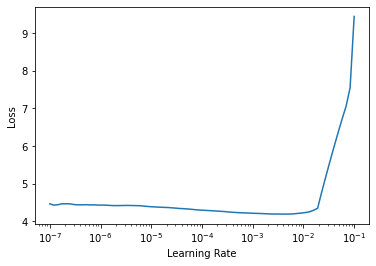

In [52]:
learn.lr_find()

The learning rate finder curve suggests picking something between 1e-4 and 1e-3.

In [53]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,perplexity,time
0,4.418393,4.117895,61.429775,23:40


Now with just one epoch of fine-tuning and not much regularization, our model did not really improve since it was already amazing. To have a look at some generated texts, let's take a prompt that looks like a wikipedia article:

In [110]:
prompt = "I love the scene when the hero "

The prompt needs to be tokenized and numericalized, so we use the same function as before to do this, before we use the `generate` method of the model.

In [111]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 8])

In [112]:
preds = learn.model.generate(inp, max_length=30, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [113]:
tokenizer.decode(preds[0].cpu().numpy())

'I love the scene when the hero \xa0comes to the aid of a young girl \xa0who has been kidnapped by a gang of thugs. '

### fin -